<a href="https://colab.research.google.com/github/bintangnabiil/Machine_Learning/blob/main/Machine_Learning_Compas_Scores_Two_Years_Week_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

df = pd.read_csv('compas-scores-two-years.csv')
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


Feature Engineering, EDA, dan Visualisasi Data

In [3]:
# INFO UMUM DATA
df.info()
df.describe()
df.isnull().sum()

# CEK KOLOM UNIK
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

Visualisasi Data

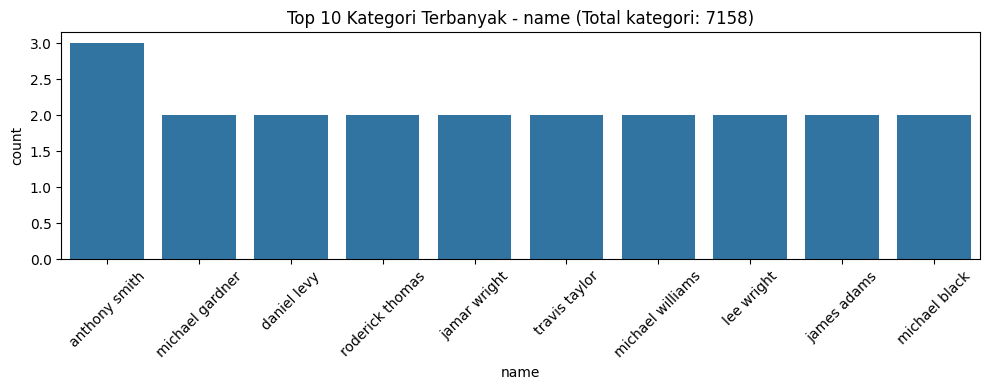

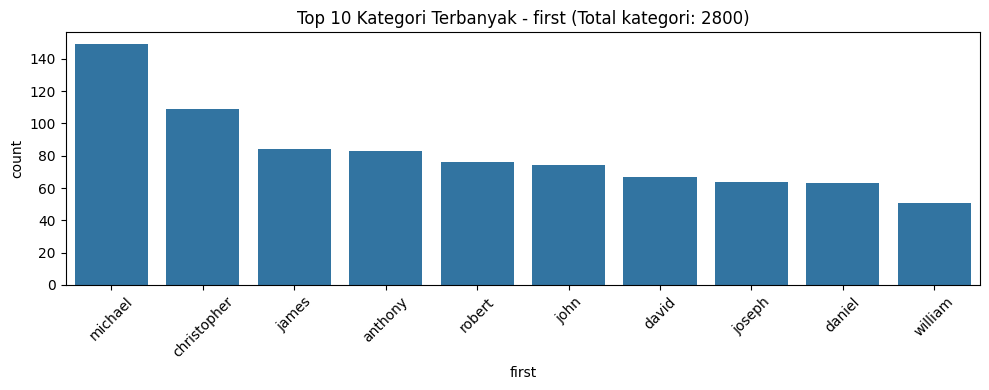

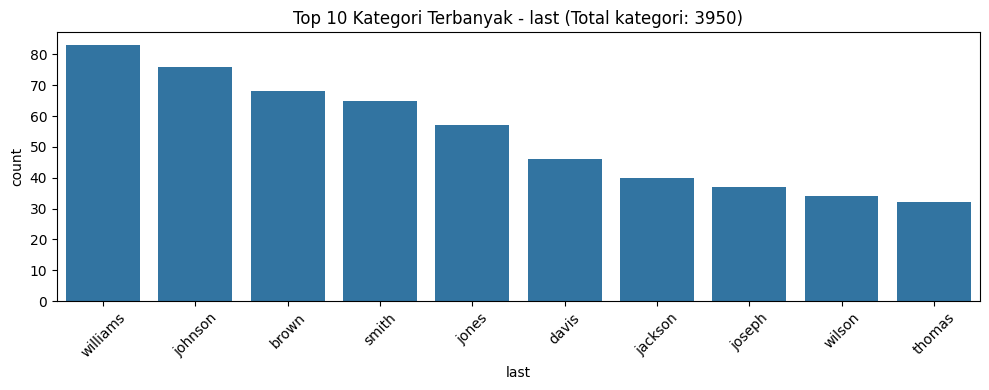

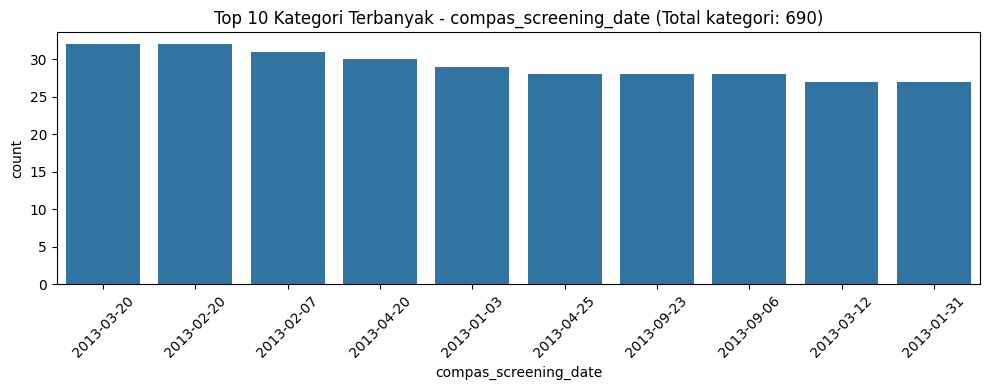

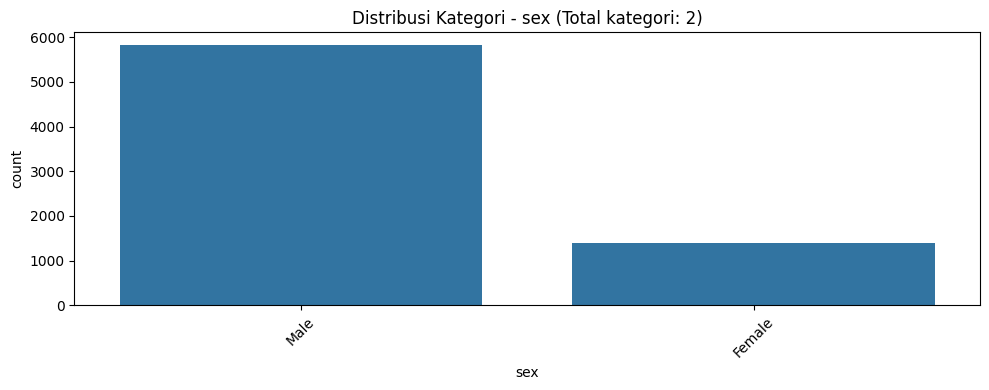

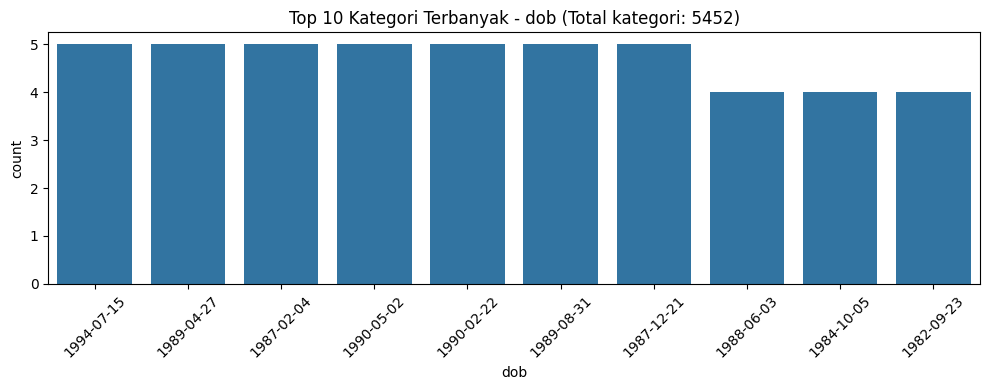

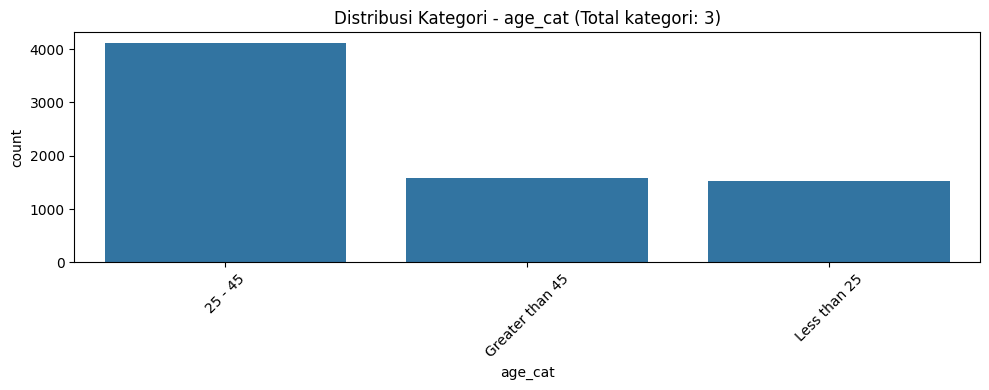

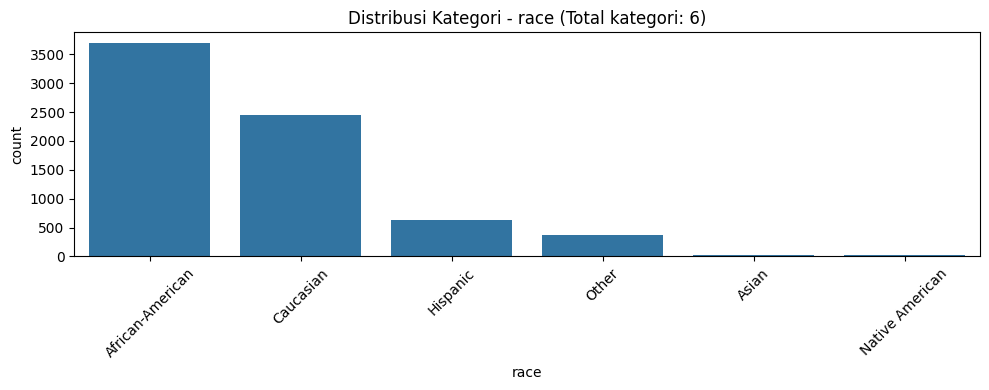

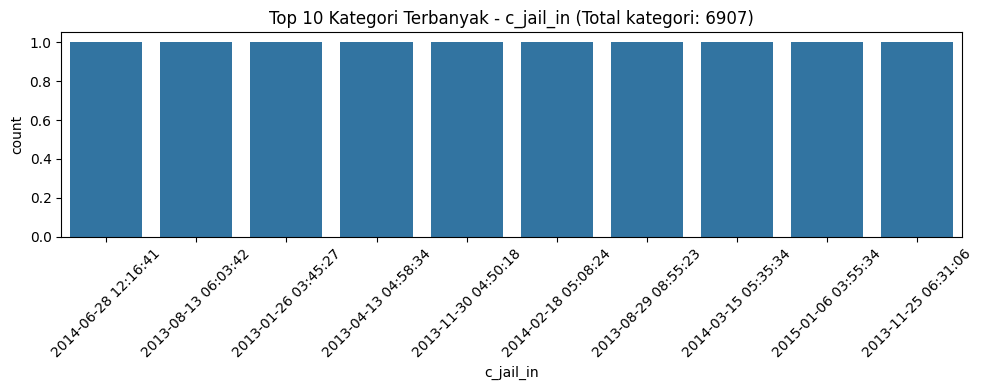

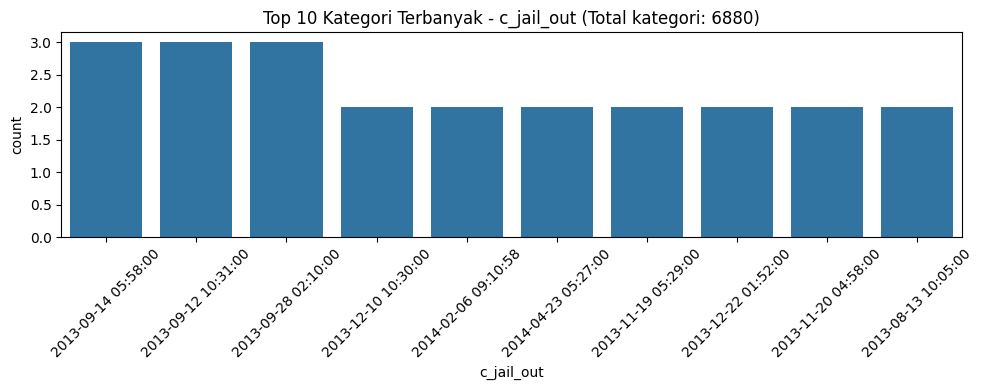

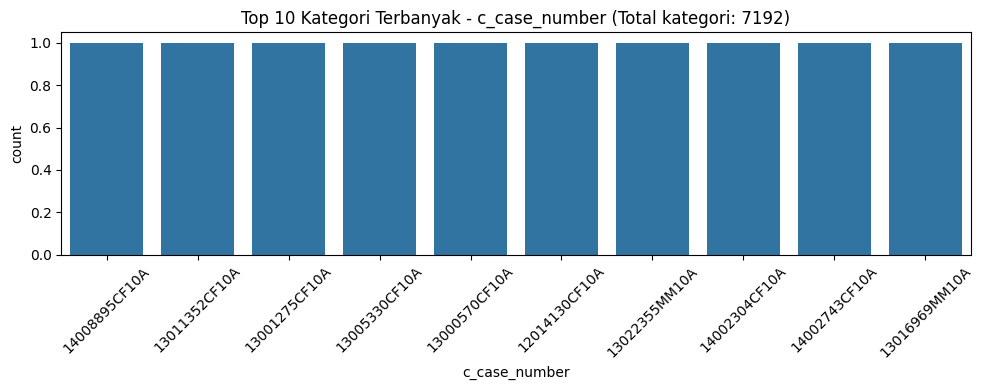

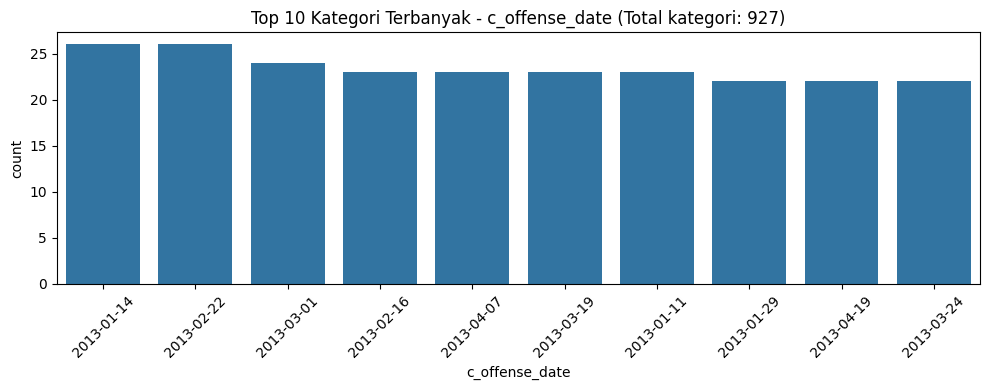

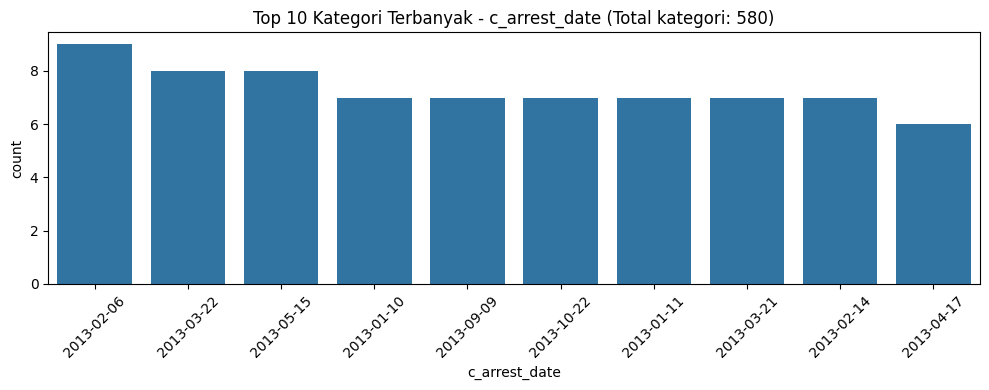

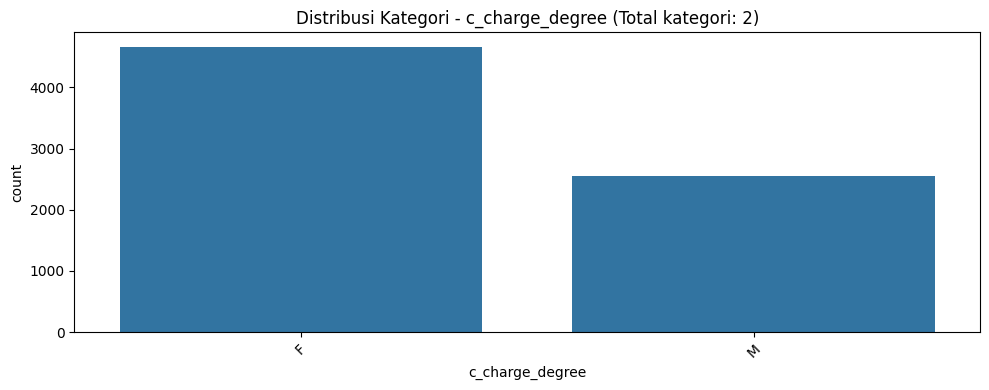

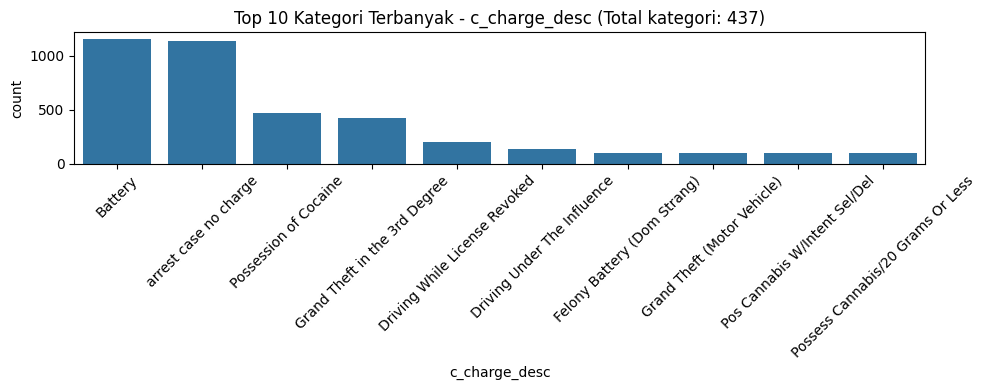

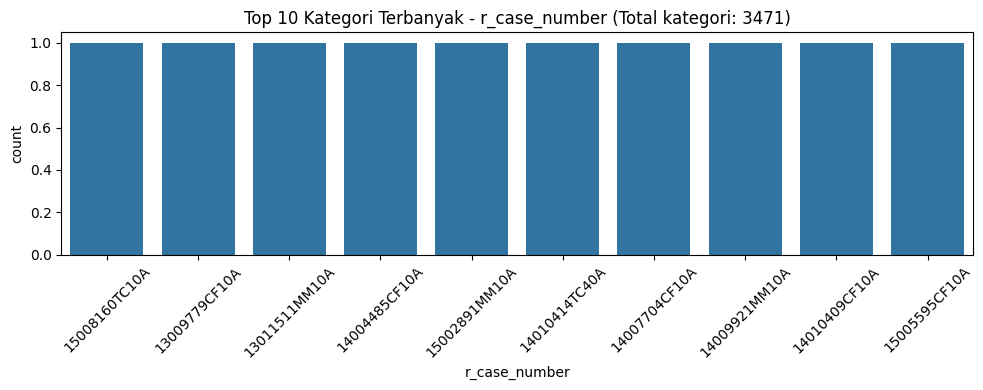

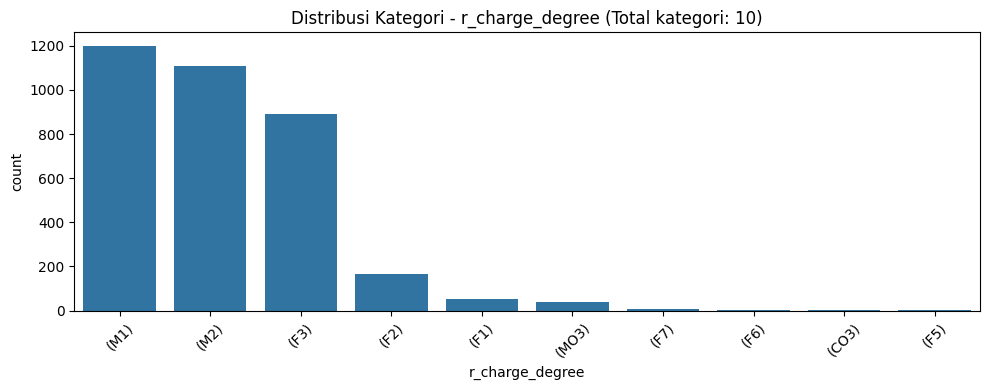

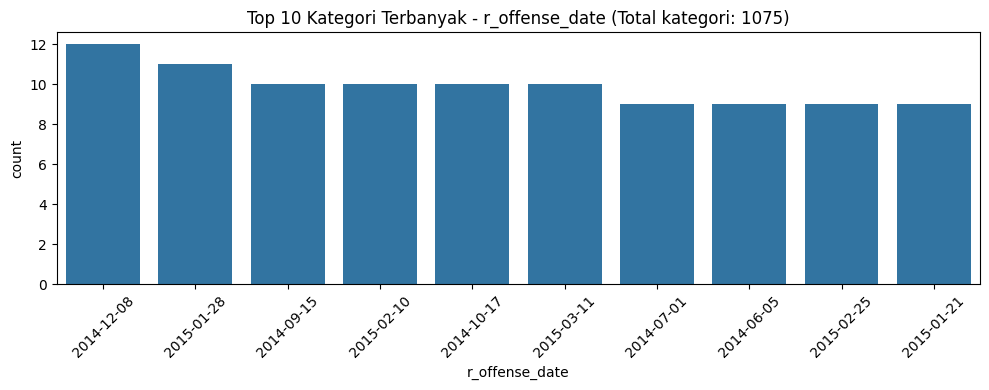

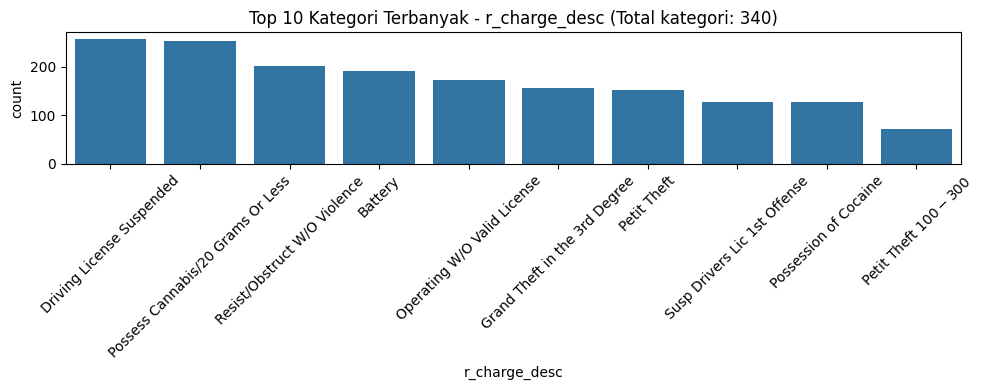

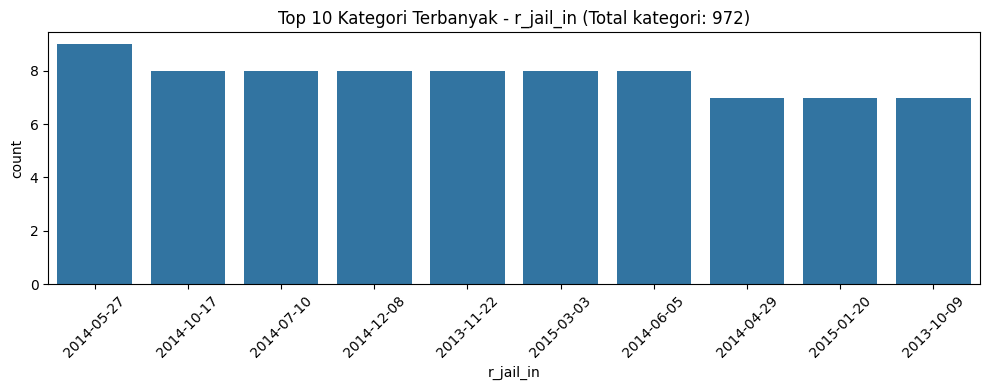

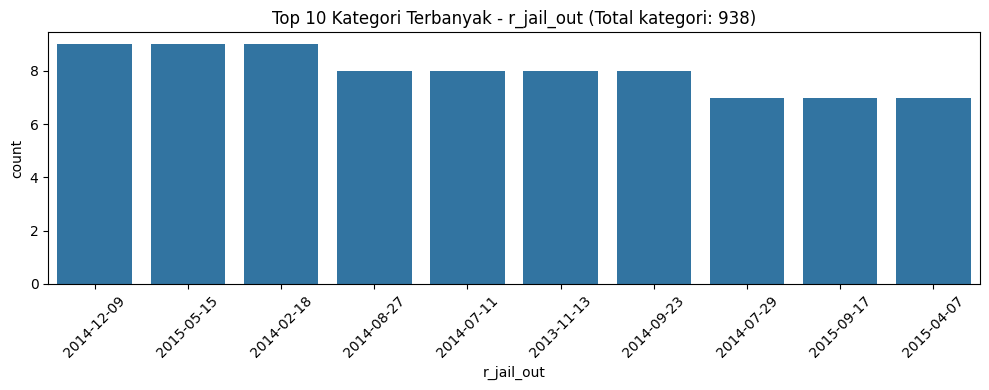

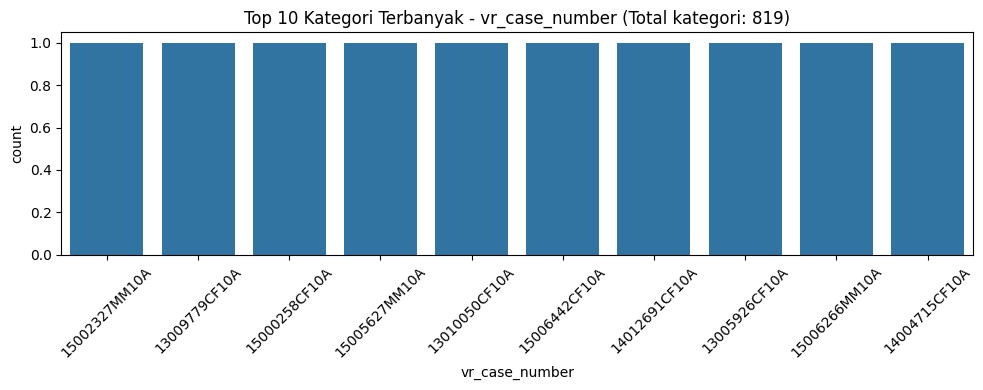

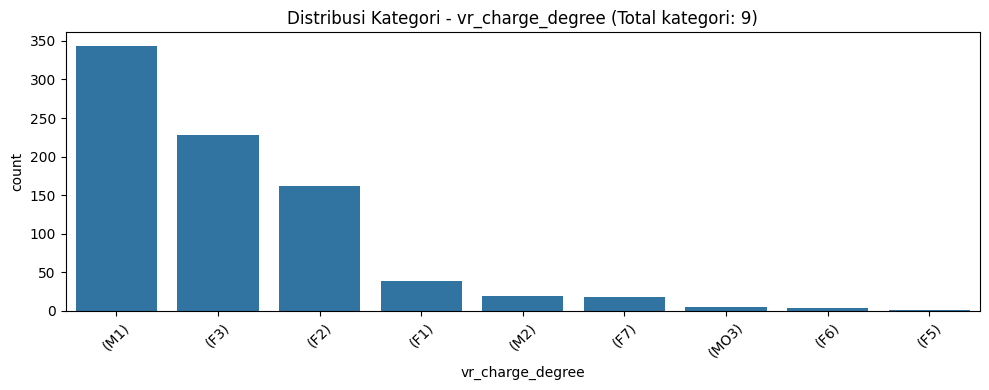

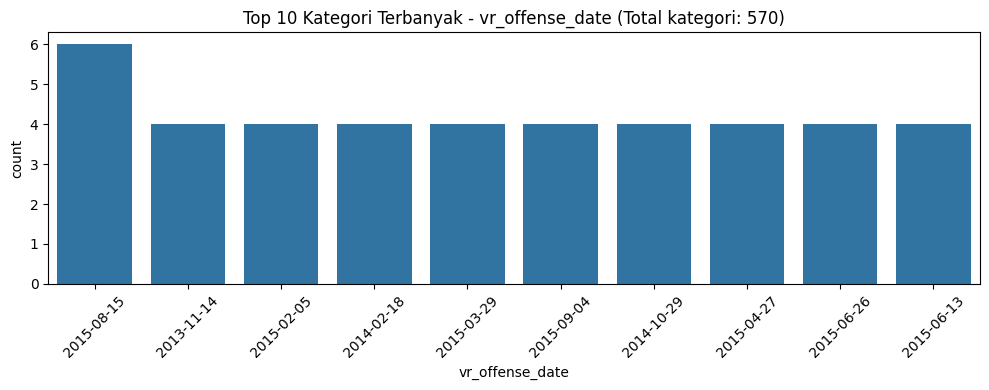

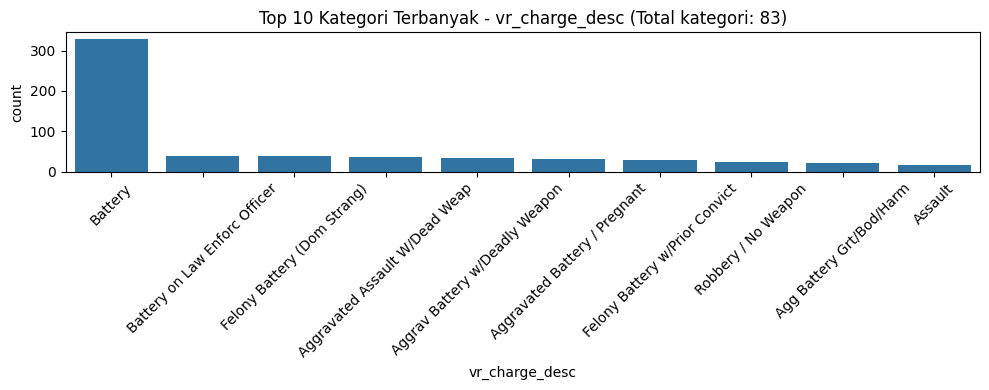

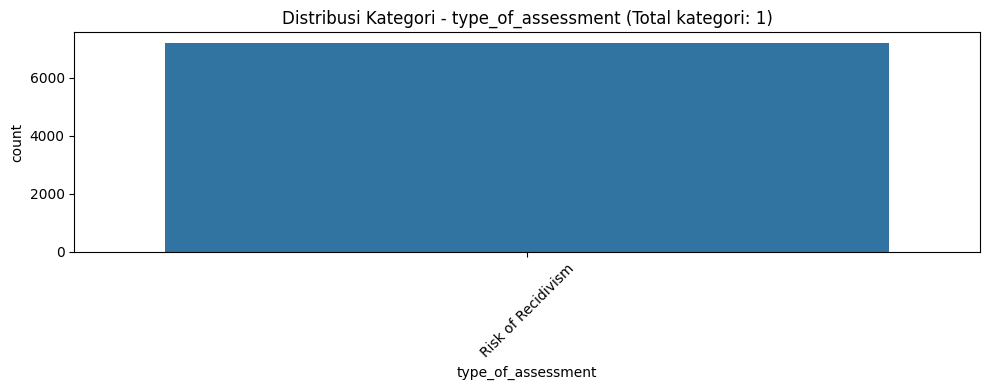

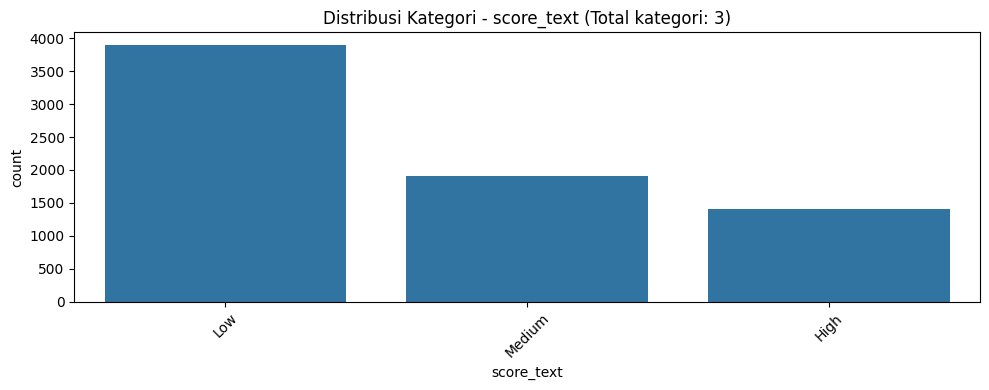

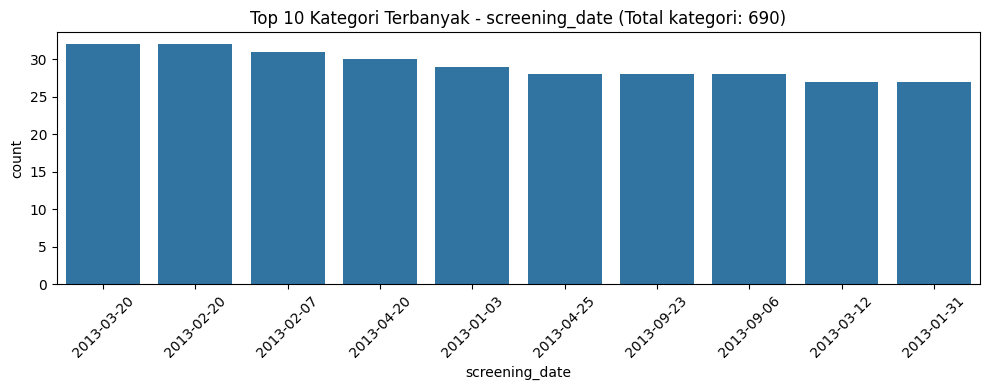

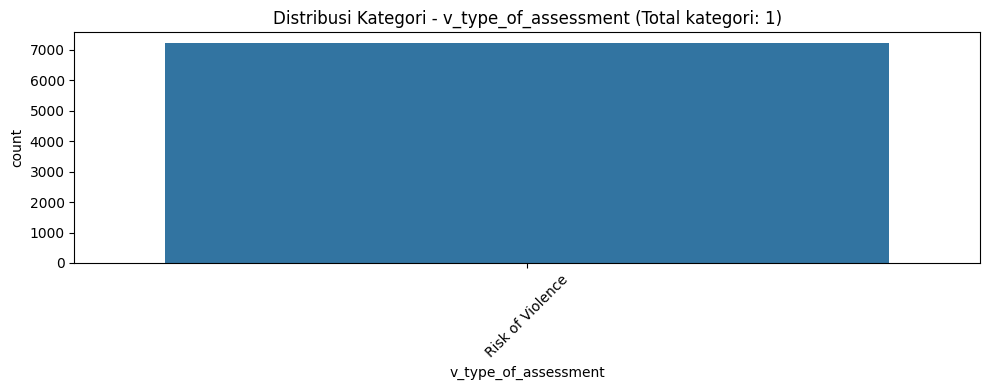

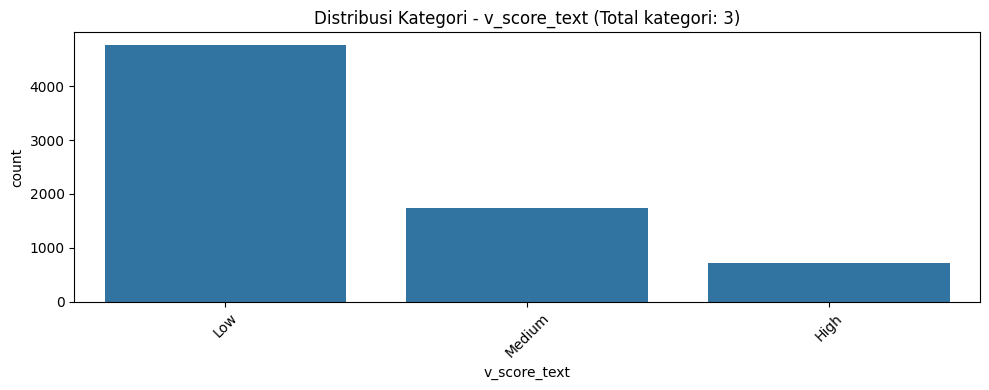

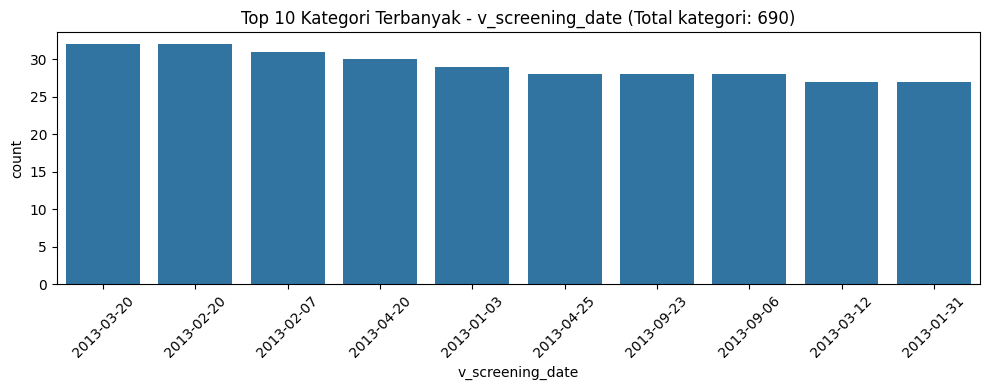

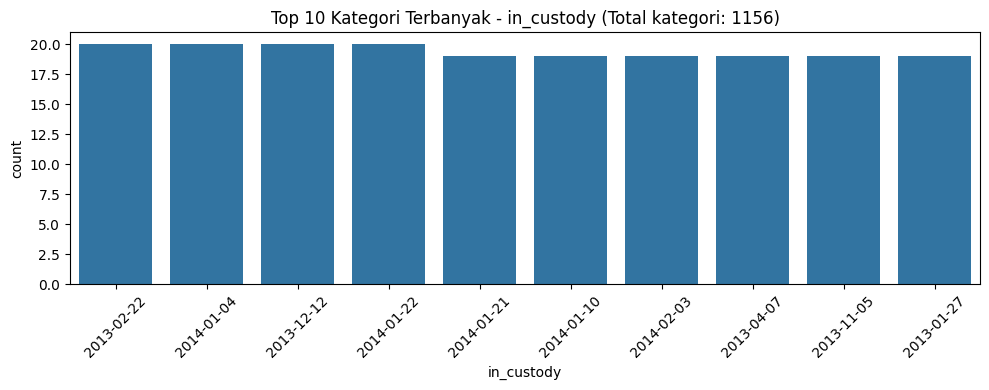

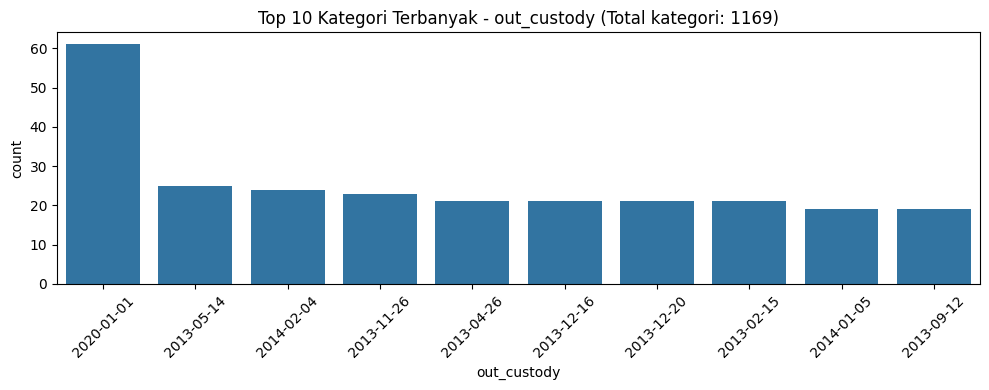

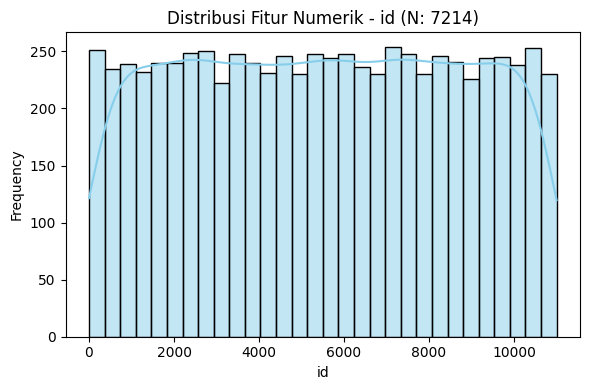

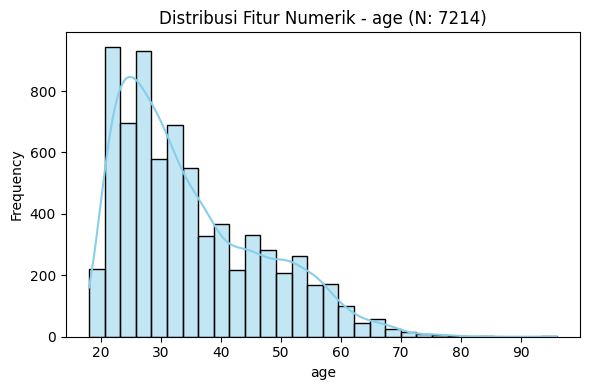

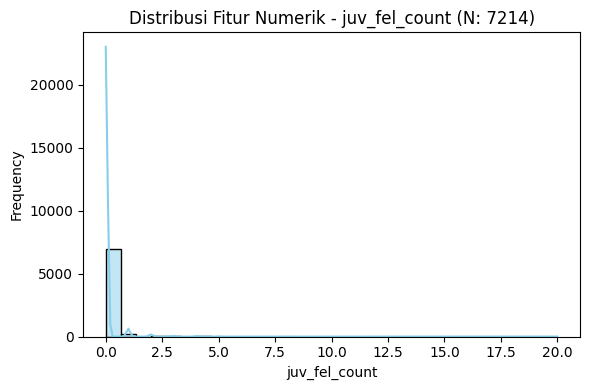

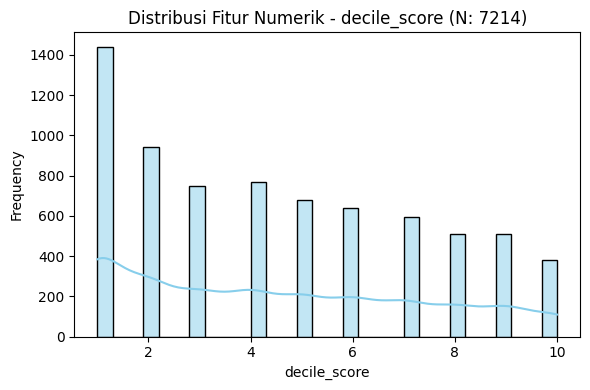

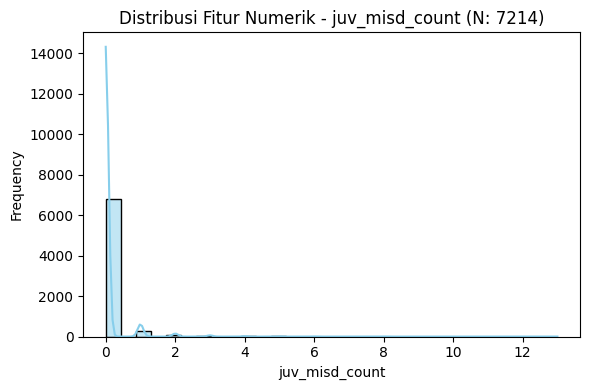

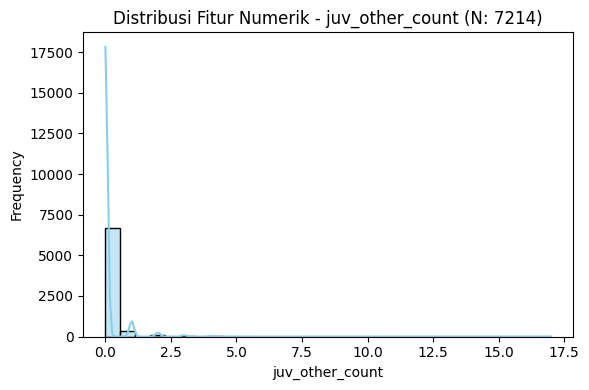

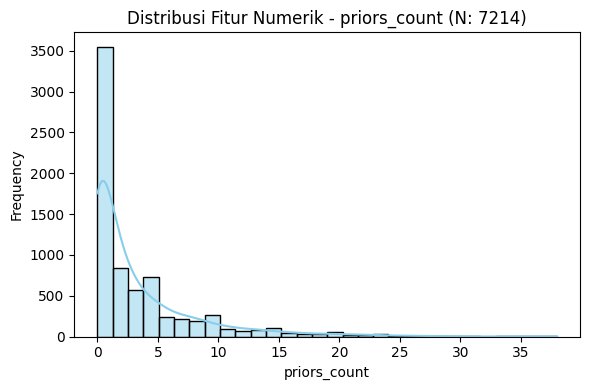

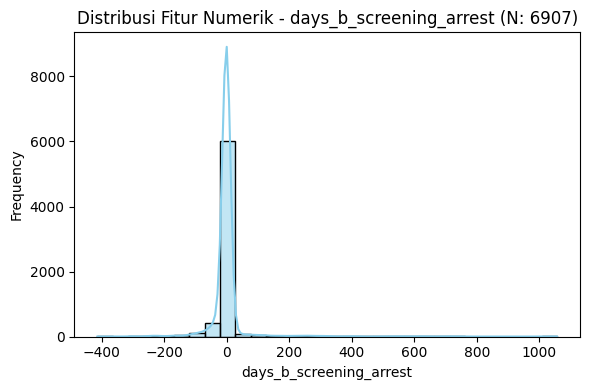

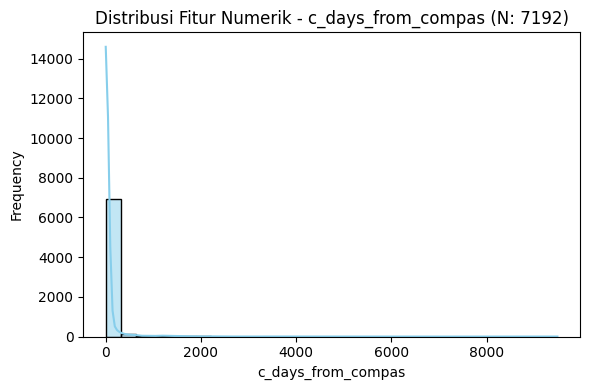

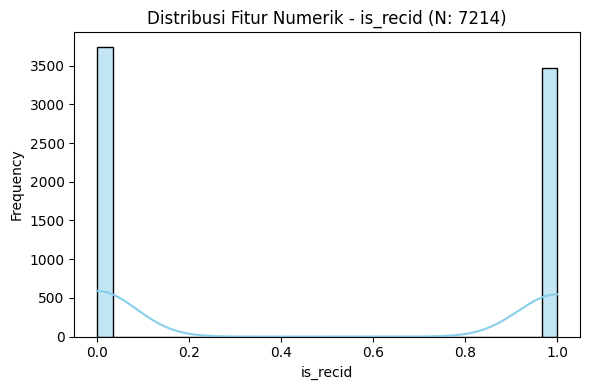

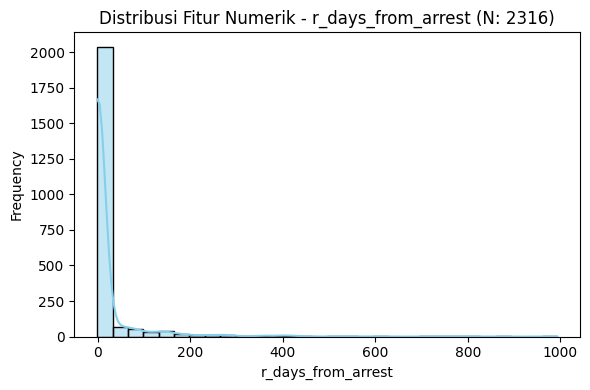

Skipping violent_recid, karena hanya punya 1 nilai unik.


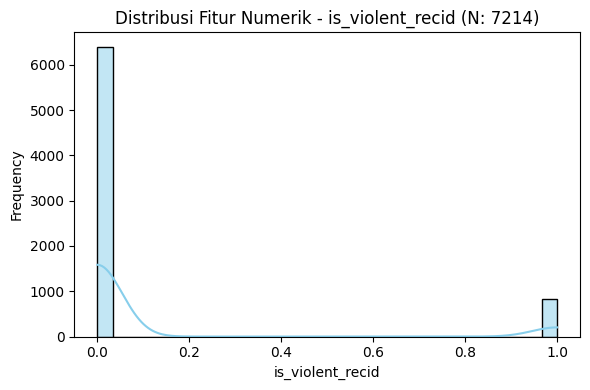

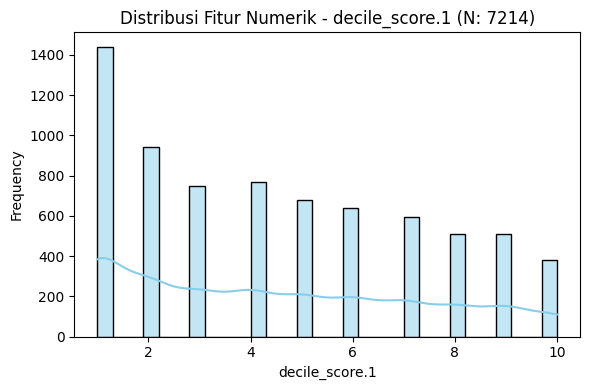

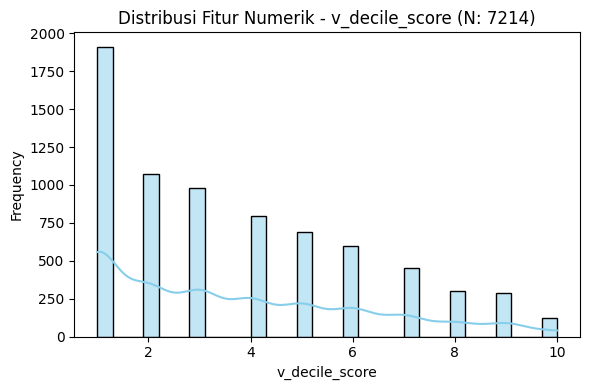

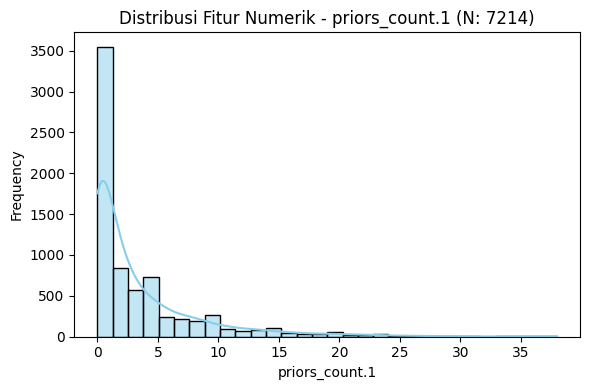

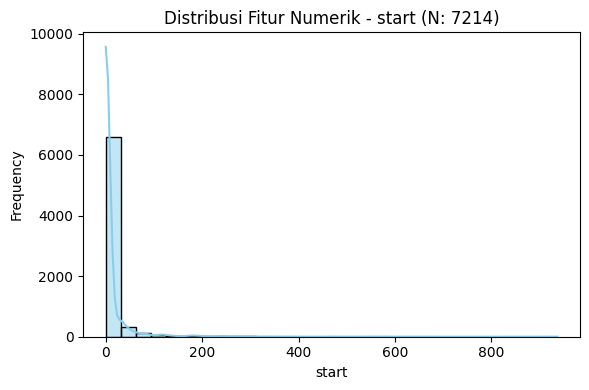

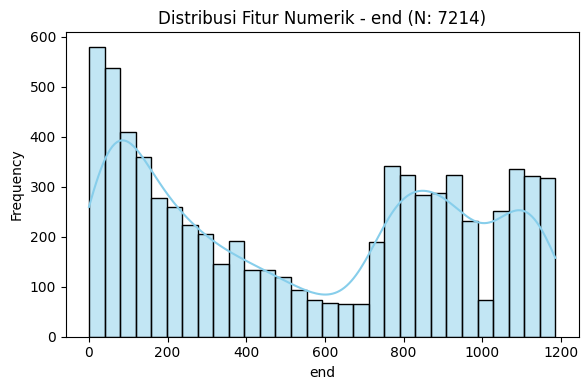

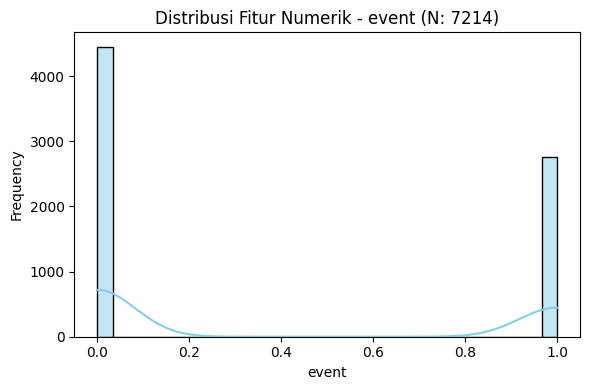

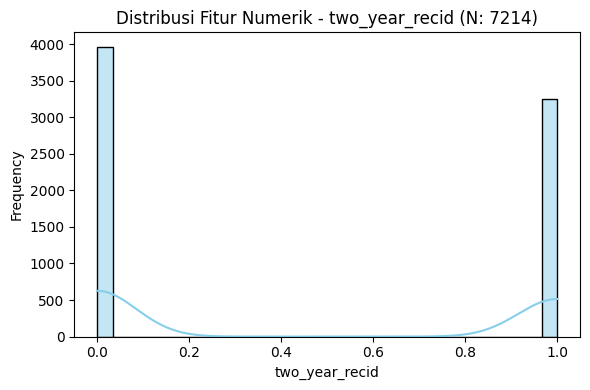

In [6]:
# VISUALISASI DATA KATEGORIK
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    num_unique = df[col].nunique()
    plt.figure(figsize=(10, 4))

    if num_unique <= 20:
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Distribusi Kategori - {col} (Total kategori: {num_unique})")
    else:
        top_categories = df[col].value_counts().nlargest(10).index
        sns.countplot(data=df[df[col].isin(top_categories)], x=col, order=top_categories)
        plt.title(f"Top 10 Kategori Terbanyak - {col} (Total kategori: {num_unique})")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# VISUALISASI DATA NUMERIK
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numerical_cols:
    num_unique = df[col].nunique()

    # Skip jika isinya konstan
    if num_unique <= 1:
        print(f"Skipping {col}, karena hanya punya 1 nilai unik.")
        continue

    # Drop NaN untuk plotting
    data = df[col].dropna()

    plt.figure(figsize=(6, 4))
    sns.histplot(data, kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribusi Fitur Numerik - {col} (N: {len(data)})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Import Library Tambahan


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

Encoding, Standarisasi, Training, dan Prediksi

In [17]:
# CEK TARGET
df.dtypes

# Drop kolom kategori dengan terlalu banyak nilai unik
too_many_categories = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() > 100]
df = df.drop(columns=too_many_categories)

# ENCODING UNTUK FITUR KATEGORIKAL
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Imputasi Missing Value
df_encoded = df_encoded.fillna(df_encoded.median(numeric_only=True))

# DROP KOLOM JIKA MASIH ADA SEMUA NILAINYA NaN ATAU CONSTANT
df_encoded = df_encoded.dropna(axis=1, how='any')
df_encoded = df_encoded.loc[:, df_encoded.nunique() > 1]

# CEK HASIL ENCODING
print("Shape sebelum encoding:", df.shape)
print("Shape sesudah encoding:", df_encoded.shape)

# PISAHKAN FITUR & LABEL
X = df_encoded.drop('two_year_recid', axis=1)
y = df_encoded['two_year_recid']

# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STANDARISASI FITUR NUMERIK
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TRAINING MODEL
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# PREDIKSI
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

Shape sebelum encoding: (7214, 31)
Shape sesudah encoding: (7214, 131)


Evaluasi Model

In [18]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Akurasi: 0.9868
Presisi: 0.9762
Recall: 0.9935
F1 Score: 0.9848
AUC: 0.9976


ROC Curve

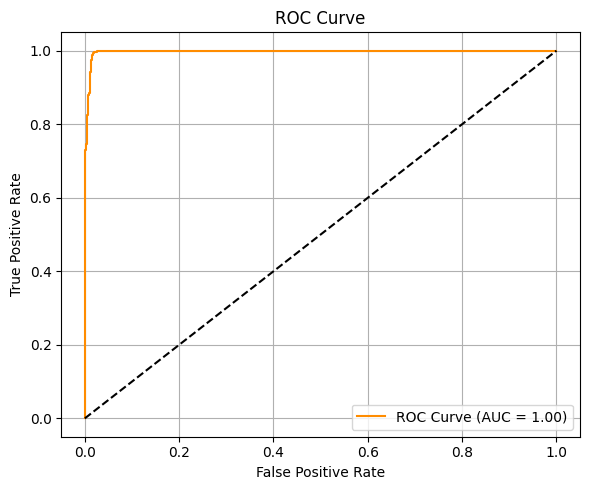

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Persamaan Matematika
##1. Confusion Matrix (Matriks Kebingungan)
Sebelum menghitung metrik evaluasi lainnya, kita perlu memahami struktur confusion matrix.

||Predicted Positive|Predicted Negative|
|-|-|-|
|Actual Postive(P)|True Positive(TP)|False Negative|
|Actual Negative (N)|False Positive(FP)|True Negative(TN)|

<br><br>
- TP (True Positive) = Kasus positif yang diprediksi benar oleh model.
- TN (True Negative) = Kasus negatif yang diprediksi benar oleh model.
- FP (False Positive) = Kasus negatif yang diprediksi salah sebagai positif.
- FN (False Negative) = Kasus positif yang diprediksi salah sebagai negatif.<br><br>

##2. Akurasi
Akurasi mengukur proporsi total prediksi yang benar dibandingkan dengan seluruh jumlah data. Ini metrik paling umum namun bisa menyesatkan saat data tidak seimbang (misalnya: jumlah negatif jauh lebih banyak dari positif).
<br><br>
Rumus Matematis:

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$
<br><br>
Semakin tinggi nilai akurasi, semakin baik model secara umum. Namun, bila dataset tidak seimbang, metrik ini perlu dilengkapi dengan metrik lain seperti precision dan recall.
<br><br>



##3. Presisi
Presisi mengukur seberapa banyak prediksi positif yang benar-benar positif. Ini penting ketika false positive memiliki konsekuensi besar, seperti dalam diagnosis penyakit.
<br><br>
Rumus Matematis:

$$
Presisi = \frac{TP}{TP + FP}
$$
<br><br>
Nilai presisi tinggi berarti model jarang memberikan prediksi positif yang salah. Misalnya, jika model memprediksi seseorang akan melakukan pelanggaran kembali, maka presisi menjawab: “Seberapa banyak yang benar-benar melakukan pelanggaran dari yang diprediksi akan melakukannya?”
<br><br>

##4. Recall (Sensitivity / True Positive Rate)
Recall menunjukkan seberapa banyak kasus positif yang berhasil ditangkap oleh model. Ini penting saat false negative berisiko tinggi.
<br><br>
Rumus Matematis:

$$
Recall = \frac{TP}{TP + FN}
$$<br><br>

Recall tinggi berarti model mampu menangkap sebagian besar kasus positif. Dalam konteks tugas ini, model dengan recall tinggi berarti lebih banyak mantan narapidana yang akan melakukan pelanggaran kembali berhasil dikenali.
<br><br>

##5. F1-Score
F1-Score adalah rata-rata harmonik dari Precision dan Recall. Cocok digunakan saat kamu ingin keseimbangan antara keduanya.
<br><br>
Rumus Matematis:

$$
F1-Score = 2 \times \frac{Precision×Recall}{Precision+Recall}
$$<br><br>

F1-score ideal untuk kasus ketidakseimbangan kelas, dan menggambarkan keseimbangan antara model yang tidak terlalu banyak menghasilkan false positive maupun false negative.
<br><br>

##6. AUC & ROC
###a) ROC (Receiver Operating Characteristic)
ROC adalah kurva yang memvisualisasikan kemampuan model membedakan antara kelas positif dan negatif, dengan menggambarkan:
- True Positive Rate (TPR) = Recall di sumbu Y
- False Positive Rate (FPR) = di sumbu X
<br><br>
Rumus Matematis:

$$
FPR = \frac{FP}{FP + TN}
$$
<br><br>

###b) AUC (Area Under Curve)
AUC adalah nilai numerik dari luas di bawah kurva ROC. Nilai AUC berkisar dari 0 hingga 1:
- 1 = model sempurna
- 0.5 = model acak
- <0.5 = model lebih buruk dari tebakan acak